In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mtcaic3/sample_submission.csv
/kaggle/input/mtcaic3/README.md
/kaggle/input/mtcaic3/validation.csv
/kaggle/input/mtcaic3/train.csv
/kaggle/input/mtcaic3/test.csv
/kaggle/input/mtcaic3/SSVEP/validation/S32/1/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/validation/S33/1/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/validation/S31/1/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/validation/S35/1/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/validation/S34/1/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/test/S39/1/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/test/S40/1/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/test/S37/1/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/test/S38/1/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/test/S36/1/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/train/S26/7/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/train/S26/2/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/train/S26/5/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/train/S26/8/EEGdata.csv
/kaggle/input/mtcaic3/SSVEP/train/S26/3/EEGdata.csv
/kaggle/input/mtcaic3/SS

In [2]:
# Cell 1: Import Libraries and Define Correct File Paths

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import os

# The data is already unzipped in the input directory.
# So, we set our BASE_PATH directly to it.
BASE_PATH = '/kaggle/input/mtcaic3/'


# Load the main CSV files that act as our index
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    sample_submission_df = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

    print("Successfully loaded all index files.")
    print("\nTraining data info:")
    train_df.info()
    print("\nFirst 5 rows of training data:")
    print(train_df.head())

except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please double-check that the BASE_PATH is correct and the files (train.csv, etc.) exist.")

Successfully loaded all index files.

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             4800 non-null   int64 
 1   subject_id     4800 non-null   object
 2   task           4800 non-null   object
 3   trial_session  4800 non-null   int64 
 4   trial          4800 non-null   int64 
 5   label          4800 non-null   object
dtypes: int64(3), object(3)
memory usage: 225.1+ KB

First 5 rows of training data:
   id subject_id task  trial_session  trial  label
0   1         S1   MI              1      1   Left
1   2         S1   MI              1      2  Right
2   3         S1   MI              1      3   Left
3   4         S1   MI              1      4   Left
4   5         S1   MI              1      5   Left


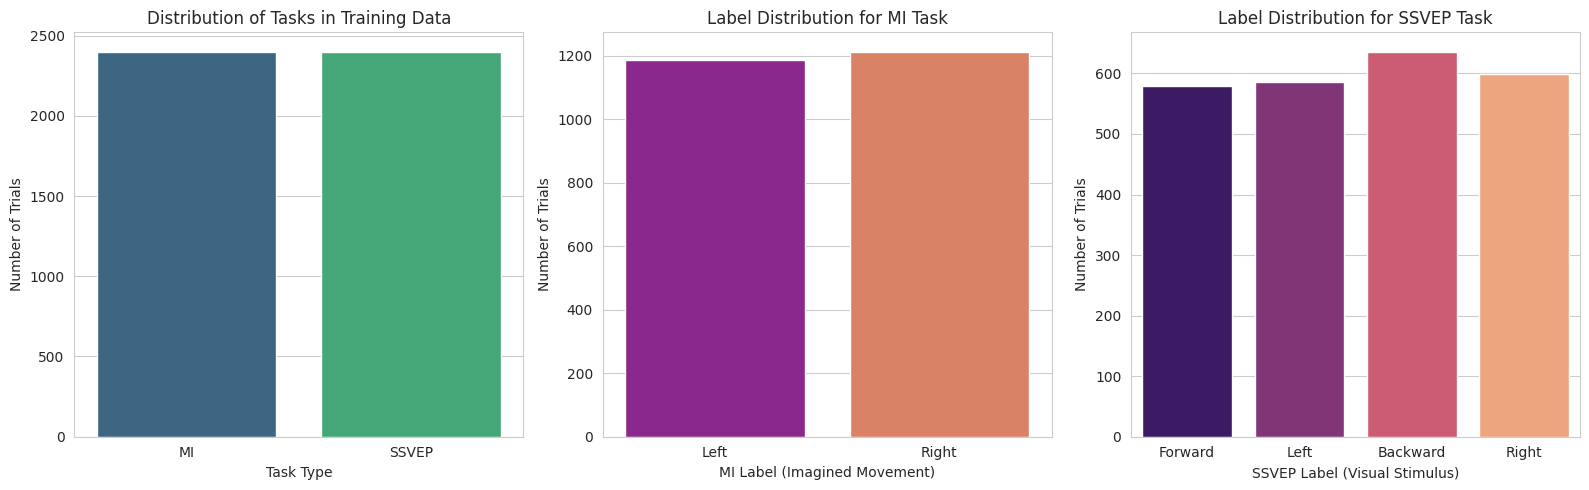

In [3]:
# Cell 2: High-Level EDA (Metadata Analysis)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 5)

# 1. Task Distribution (MI vs SSVEP)
plt.subplot(1, 3, 1)
sns.countplot(x='task', data=train_df, palette='viridis')
plt.title('Distribution of Tasks in Training Data')
plt.ylabel('Number of Trials')
plt.xlabel('Task Type')

# 2. Label Distribution for MI Task
plt.subplot(1, 3, 2)
mi_df = train_df[train_df['task'] == 'MI']
sns.countplot(x='label', data=mi_df, palette='plasma')
plt.title('Label Distribution for MI Task')
plt.ylabel('Number of Trials')
plt.xlabel('MI Label (Imagined Movement)')

# 3. Label Distribution for SSVEP Task
plt.subplot(1, 3, 3)
ssvep_df = train_df[train_df['task'] == 'SSVEP']
sns.countplot(x='label', data=ssvep_df, palette='magma')
plt.title('Label Distribution for SSVEP Task')
plt.ylabel('Number of Trials')
plt.xlabel('SSVEP Label (Visual Stimulus)')

plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from mne.decoding import CSP
import mne
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Load index files
base_path = '/kaggle/input/mtcaic3/'  # Replace with the path to the dataset directory if needed
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
validation_df = pd.read_csv(os.path.join(base_path, 'validation.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))

# Function to load a trial's EEG data
def load_trial_data(row, base_path='.'):
    # Determine dataset type based on ID range
    id_num = row['id']
    if id_num <= 4800:
        dataset = 'train'
    elif id_num <= 4900:
        dataset = 'validation'
    else:
        dataset = 'test'
    
    # Construct the path to EEGdata.csv
    eeg_path = f"{base_path}/{row['task']}/{dataset}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    
    # Load the entire EEG file
    eeg_data = pd.read_csv(eeg_path)
    
    # Calculate indices for the specific trial
    trial_num = int(row['trial'])
    if row['task'] == 'MI':
        samples_per_trial = 2250  # 9 seconds * 250 Hz
    else:  # SSVEP
        samples_per_trial = 1750  # 7 seconds * 250 Hz
    
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial - 1
    
    # Extract the trial data
    trial_data = eeg_data.iloc[start_idx:end_idx+1]
    return trial_data

# EEG channel names
eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']

# Preprocessing functions
def apply_bandpass_filter(data, low_freq, high_freq, fs=250):
    """Apply bandpass filter to EEG data"""
    nyq = 0.5 * fs
    low = low_freq / nyq
    high = high_freq / nyq
    b, a = signal.butter(4, [low, high], btype='band')
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered_data[:, i] = signal.filtfilt(b, a, data[:, i])
    return filtered_data

def apply_notch_filter(data, notch_freq=50, fs=250):
    """Apply notch filter to remove power line noise"""
    nyq = 0.5 * fs
    notch = notch_freq / nyq
    b, a = signal.iirnotch(notch, 30, fs)
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered_data[:, i] = signal.filtfilt(b, a, data[:, i])
    return filtered_data

def preprocess_eeg(data, task):
    """Preprocess EEG data based on task type with improved filtering"""
    # Extract EEG channels only
    eeg_data = data[eeg_channels].values
    
    # Apply notch filter to remove power line noise
    eeg_data = apply_notch_filter(eeg_data)
    
    # Apply appropriate bandpass filter based on task
    if task == 'MI':
        # More focused motor imagery band (8-30 Hz)
        eeg_data = apply_bandpass_filter(eeg_data, 8, 30)
        
        # Apply spatial filtering (CAR - Common Average Reference)
        eeg_data = eeg_data - np.mean(eeg_data, axis=1, keepdims=True)
    else:  # SSVEP
        # Wider band to capture all SSVEP frequencies (5-45 Hz)
        eeg_data = apply_bandpass_filter(eeg_data, 5, 45)
        
        # Apply spatial filtering (Laplacian)
        # Simple implementation for the occipital channels
        occipital_idx = [eeg_channels.index(ch) for ch in ['PO7', 'OZ', 'PO8']]
        for idx in occipital_idx:
            neighbors = [i for i in range(len(eeg_channels)) if i != idx]
            eeg_data[:, idx] = eeg_data[:, idx] - np.mean(eeg_data[:, neighbors], axis=1)
    
    return eeg_data

# Feature extraction functions
def extract_psd_features(eeg_data, fs=250, nperseg=250):
    """Extract Power Spectral Density features"""
    features = []
    for ch in range(eeg_data.shape[1]):
        f, psd = signal.welch(eeg_data[:, ch], fs=fs, nperseg=nperseg)
        # Select relevant frequency bands
        delta_idx = np.logical_and(f >= 1, f <= 4)
        theta_idx = np.logical_and(f >= 4, f <= 8)
        alpha_idx = np.logical_and(f >= 8, f <= 13)
        beta_idx = np.logical_and(f >= 13, f <= 30)
        gamma_idx = np.logical_and(f >= 30, f <= 45)
        
        # Calculate band powers
        delta_power = np.mean(psd[delta_idx])
        theta_power = np.mean(psd[theta_idx])
        alpha_power = np.mean(psd[alpha_idx])
        beta_power = np.mean(psd[beta_idx])
        gamma_power = np.mean(psd[gamma_idx])
        
        # Add specific SSVEP frequencies
        ssvep_7hz = np.mean(psd[np.logical_and(f >= 6.5, f <= 7.5)])  # Forward
        ssvep_8hz = np.mean(psd[np.logical_and(f >= 7.5, f <= 8.5)])  # Backward
        ssvep_10hz = np.mean(psd[np.logical_and(f >= 9.5, f <= 10.5)])  # Left
        ssvep_13hz = np.mean(psd[np.logical_and(f >= 12.5, f <= 13.5)])  # Right
        
        features.extend([delta_power, theta_power, alpha_power, beta_power, gamma_power,
                         ssvep_7hz, ssvep_8hz, ssvep_10hz, ssvep_13hz])
    
    return np.array(features)

def extract_time_features(eeg_data):
    """Extract time domain features"""
    features = []
    for ch in range(eeg_data.shape[1]):
        # Statistical features
        mean = np.mean(eeg_data[:, ch])
        std = np.std(eeg_data[:, ch])
        max_val = np.max(eeg_data[:, ch])
        min_val = np.min(eeg_data[:, ch])
        kurtosis = np.mean((eeg_data[:, ch] - mean)**4) / (std**4) if std > 0 else 0
        skewness = np.mean((eeg_data[:, ch] - mean)**3) / (std**3) if std > 0 else 0
        
        features.extend([mean, std, max_val, min_val, kurtosis, skewness])
    
    return np.array(features)

def extract_connectivity_features(eeg_data):
    """Extract connectivity features between channels"""
    n_channels = eeg_data.shape[1]
    features = []
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(eeg_data.T)
    
    # Extract upper triangle of correlation matrix (excluding diagonal)
    upper_tri_idx = np.triu_indices(n_channels, k=1)
    connectivity_features = corr_matrix[upper_tri_idx]
    
    features.extend(connectivity_features)
    
    return np.array(features)

def extract_features_mi(eeg_data):
    """Extract features specifically for MI task"""
    # Basic features
    psd_features = extract_psd_features(eeg_data)
    time_features = extract_time_features(eeg_data)
    connectivity_features = extract_connectivity_features(eeg_data)
    
    # Add ERD/ERS features (Event-Related Desynchronization/Synchronization)
    # Calculate power in mu (8-12 Hz) and beta (13-30 Hz) bands
    fs = 250  # Sampling frequency
    
    # Calculate baseline and active periods
    baseline_period = eeg_data[:250, :]  # First second as baseline
    active_period = eeg_data[500:, :]    # After 2 seconds as active period
    
    # Calculate ERD/ERS features
    mu_band = apply_bandpass_filter(eeg_data, 8, 12)
    beta_band = apply_bandpass_filter(eeg_data, 13, 30)
    
    # Power in baseline and active periods
    mu_baseline_power = np.mean(mu_band[:250, :]**2, axis=0)
    mu_active_power = np.mean(mu_band[500:, :]**2, axis=0)
    beta_baseline_power = np.mean(beta_band[:250, :]**2, axis=0)
    beta_active_power = np.mean(beta_band[500:, :]**2, axis=0)
    
    # ERD/ERS calculation
    mu_erd = (mu_active_power - mu_baseline_power) / (mu_baseline_power + 1e-10) * 100
    beta_erd = (beta_active_power - beta_baseline_power) / (beta_baseline_power + 1e-10) * 100
    
    # Add laterality features (difference between left and right hemispheres)
    left_idx = [eeg_channels.index(ch) for ch in ['C3', 'PO7']]
    right_idx = [eeg_channels.index(ch) for ch in ['C4', 'PO8']]
    
    left_mu_power = np.mean(mu_active_power[left_idx])
    right_mu_power = np.mean(mu_active_power[right_idx])
    left_beta_power = np.mean(beta_active_power[left_idx])
    right_beta_power = np.mean(beta_active_power[right_idx])
    
    laterality_mu = left_mu_power - right_mu_power
    laterality_beta = left_beta_power - right_beta_power
    
    # Combine all features
    combined_features = np.concatenate([psd_features, time_features, connectivity_features, 
                                       mu_erd, beta_erd, [laterality_mu, laterality_beta]])
    
    return combined_features

def extract_features_ssvep(eeg_data):
    """Extract features specifically for SSVEP task"""
    # Basic features
    psd_features = extract_psd_features(eeg_data)
    time_features = extract_time_features(eeg_data)
    connectivity_features = extract_connectivity_features(eeg_data)
    
    # SSVEP stimulus frequencies
    stim_freqs = [7, 8, 10, 13]  # Forward, Backward, Left, Right
    fs = 250  # Sampling frequency
    
    # Enhanced SSVEP features - focus on occipital channels
    occipital_idx = [eeg_channels.index(ch) for ch in ['PO7', 'OZ', 'PO8']]
    
    # Calculate power at stimulus frequencies and harmonics
    ssvep_features = []
    for ch_idx in occipital_idx:
        f, psd = signal.welch(eeg_data[:, ch_idx], fs=fs, nperseg=1024)
        
        for freq in stim_freqs:
            # Find power at stimulus frequency and its harmonics
            for harmonic in range(1, 4):  # Include up to 3 harmonics
                target_freq = freq * harmonic
                idx = np.argmin(np.abs(f - target_freq))
                ssvep_features.append(psd[idx])
                
                # Add power in narrow band around the frequency
                band_idx = np.logical_and(f >= target_freq-0.5, f <= target_freq+0.5)
                ssvep_features.append(np.mean(psd[band_idx]))
    
    # Add canonical correlation analysis (CCA) inspired features
    # Simplified version: correlation between EEG and sine/cosine at stimulus frequencies
    cca_features = []
    for freq in stim_freqs:
        t = np.arange(0, eeg_data.shape[0]) / fs
        sin_ref = np.sin(2 * np.pi * freq * t)
        cos_ref = np.cos(2 * np.pi * freq * t)
        
        for ch_idx in occipital_idx:
            corr_sin = np.abs(np.corrcoef(eeg_data[:, ch_idx], sin_ref)[0, 1])
            corr_cos = np.abs(np.corrcoef(eeg_data[:, ch_idx], cos_ref)[0, 1])
            cca_features.extend([corr_sin, corr_cos])
    
    # Combine all features
    combined_features = np.concatenate([psd_features, time_features, connectivity_features, 
                                       np.array(ssvep_features), np.array(cca_features)])
    
    return combined_features

def prepare_dataset(df, base_path='.'):
    X_mi = []
    X_ssvep = []
    y_mi = []
    y_ssvep = []
    ids_mi = []
    ids_ssvep = []
    
    for idx, row in df.iterrows():
        try:
            # Load trial data
            trial_data = load_trial_data(row, base_path=base_path)
            
            # Preprocess EEG data
            eeg_data = preprocess_eeg(trial_data, row['task'])
            
            # Extract features based on task type
            if row['task'] == 'MI':
                features = extract_features_mi(eeg_data)
                # Check if features have valid values
                if np.any(np.isnan(features)) or np.any(np.isinf(features)):
                    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
                X_mi.append(features)
                if 'label' in row:
                    y_mi.append(row['label'])
                ids_mi.append(row['id'])
            else:  # SSVEP
                features = extract_features_ssvep(eeg_data)
                # Check if features have valid values
                if np.any(np.isnan(features)) or np.any(np.isinf(features)):
                    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
                X_ssvep.append(features)
                if 'label' in row:
                    y_ssvep.append(row['label'])
                ids_ssvep.append(row['id'])
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
    
    # Convert to numpy arrays
    X_mi = np.array(X_mi)
    X_ssvep = np.array(X_ssvep)
    
    if y_mi:
        y_mi = np.array(y_mi)
    if y_ssvep:
        y_ssvep = np.array(y_ssvep)
    
    ids_mi = np.array(ids_mi)
    ids_ssvep = np.array(ids_ssvep)
    
    return X_mi, X_ssvep, y_mi, y_ssvep, ids_mi, ids_ssvep

# Prepare training and validation datasets
print("Preparing training dataset...")
X_train_mi, X_train_ssvep, y_train_mi, y_train_ssvep, ids_train_mi, ids_train_ssvep = prepare_dataset(train_df, base_path=base_path)
print("Preparing validation dataset...")
X_val_mi, X_val_ssvep, y_val_mi, y_val_ssvep, ids_val_mi, ids_val_ssvep = prepare_dataset(validation_df, base_path=base_path)

# Create label encoders for MI and SSVEP tasks
mi_label_encoder = LabelEncoder()
ssvep_label_encoder = LabelEncoder()

# Fit and transform the labels
y_train_mi_encoded = mi_label_encoder.fit_transform(y_train_mi)
y_train_ssvep_encoded = ssvep_label_encoder.fit_transform(y_train_ssvep)

# Also encode validation labels
y_val_mi_encoded = mi_label_encoder.transform(y_val_mi)
y_val_ssvep_encoded = ssvep_label_encoder.transform(y_val_ssvep)

# Print unique classes to verify encoding
print(f"MI classes: {mi_label_encoder.classes_}")
print(f"SSVEP classes: {ssvep_label_encoder.classes_}")
print(f"MI encoded classes: {np.unique(y_train_mi_encoded)}")
print(f"SSVEP encoded classes: {np.unique(y_train_ssvep_encoded)}")




    








Preparing training dataset...
Preparing validation dataset...
MI classes: ['Left' 'Right']
SSVEP classes: ['Backward' 'Forward' 'Left' 'Right']
MI encoded classes: [0 1]
SSVEP encoded classes: [0 1 2 3]


In [5]:
# Import TensorFlow and related libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Prepare data for deep learning
# Scale the data
from sklearn.preprocessing import MinMaxScaler
mi_scaler = MinMaxScaler()
ssvep_scaler = MinMaxScaler()

X_train_mi_scaled = mi_scaler.fit_transform(X_train_mi)
X_val_mi_scaled = mi_scaler.transform(X_val_mi)

X_train_ssvep_scaled = ssvep_scaler.fit_transform(X_train_ssvep)
X_val_ssvep_scaled = ssvep_scaler.transform(X_val_ssvep)

# Convert labels to one-hot encoding
y_train_mi_onehot = to_categorical(y_train_mi_encoded)
y_val_mi_onehot = to_categorical(y_val_mi_encoded)
y_train_ssvep_onehot = to_categorical(y_train_ssvep_encoded)
y_val_ssvep_onehot = to_categorical(y_val_ssvep_encoded)

# Define a deep neural network model for classification
def create_dnn_model(input_shape, num_classes):
    model = Sequential([
# Input layer
        Dense(512, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.5),
        
        # Hidden layers
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)



2025-06-28 01:05:25.001731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751072725.026059     109 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751072725.032843     109 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Train MI model
print("Training deep learning MI model...")
mi_model = create_dnn_model(
    input_shape=X_train_mi_scaled.shape[1],
    num_classes=len(np.unique(y_train_mi_encoded))
)

mi_history = mi_model.fit(
    X_train_mi_scaled,
    y_train_mi_onehot,
    validation_data=(X_val_mi_scaled, y_val_mi_onehot),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate MI model
mi_val_pred_proba = mi_model.predict(X_val_mi_scaled)
mi_val_pred_encoded = np.argmax(mi_val_pred_proba, axis=1)
mi_val_pred = mi_label_encoder.inverse_transform(mi_val_pred_encoded)
mi_val_acc = accuracy_score(y_val_mi, mi_val_pred)
print(f"Deep Learning MI Validation Accuracy: {mi_val_acc:.4f}")

Training deep learning MI model...


2025-06-28 01:05:29.395244: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4724 - loss: 1.0444 - val_accuracy: 0.5400 - val_loss: 0.6894 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5182 - loss: 0.8216 - val_accuracy: 0.5000 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5124 - loss: 0.7752 - val_accuracy: 0.4800 - val_loss: 0.7120 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5244 - loss: 0.7443 - val_accuracy: 0.4800 - val_loss: 0.7052 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5172 - loss: 0.7219 - val_accuracy: 0.4200 - val_loss: 0.7334 - learning_rate: 0.0010
Epoch 6/100
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5117 - loss: 0.7189
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5120 - loss: 0.7186 - val_acc

In [7]:
# Train SSVEP model
print("Training deep learning SSVEP model...")
ssvep_model = create_dnn_model(
    input_shape=X_train_ssvep_scaled.shape[1],
    num_classes=len(np.unique(y_train_ssvep_encoded))
)

ssvep_history = ssvep_model.fit(
    X_train_ssvep_scaled,
    y_train_ssvep_onehot,
    validation_data=(X_val_ssvep_scaled, y_val_ssvep_onehot),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
# Evaluate SSVEP model
ssvep_val_pred_proba = ssvep_model.predict(X_val_ssvep_scaled)
ssvep_val_pred_encoded = np.argmax(ssvep_val_pred_proba, axis=1)
ssvep_val_pred = ssvep_label_encoder.inverse_transform(ssvep_val_pred_encoded)
ssvep_val_acc = accuracy_score(y_val_ssvep, ssvep_val_pred)
print(f"Deep Learning SSVEP Validation Accuracy: {ssvep_val_acc:.4f}")

# Overall validation accuracy
val_pred = np.concatenate([mi_val_pred, ssvep_val_pred])
val_true = np.concatenate([y_val_mi, y_val_ssvep])
val_acc = accuracy_score(val_true, val_pred)
print(f"Deep Learning Overall Validation Accuracy: {val_acc:.4f}")

# Prepare test dataset and generate predictions
print("Preparing test dataset...")
X_test_mi, X_test_ssvep, _, _, ids_test_mi, ids_test_ssvep = prepare_dataset(test_df, base_path=base_path)

# Scale test data
X_test_mi_scaled = mi_scaler.transform(X_test_mi)
X_test_ssvep_scaled = ssvep_scaler.transform(X_test_ssvep)

Training deep learning SSVEP model...
Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.2334 - loss: 1.9891 - val_accuracy: 0.2800 - val_loss: 1.4582 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2547 - loss: 1.6915 - val_accuracy: 0.2000 - val_loss: 1.4019 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2589 - loss: 1.6100 - val_accuracy: 0.2800 - val_loss: 1.4681 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2636 - loss: 1.5376 - val_accuracy: 0.2800 - val_loss: 1.6128 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2496 - loss: 1.5166 - val_accuracy: 0.2200 - val_loss: 1.5594 - learning_rate: 0.0010
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2470 - loss: 1.4784 - val_accuracy: 0.3000 - val_loss: 1.5893 - learning_rate: 0.0010
Epoch 7/100
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - ac

In [8]:
# Generate predictions for test set
print("Generating test predictions...")
mi_test_pred_proba = mi_model.predict(X_test_mi_scaled)
mi_test_pred_encoded = np.argmax(mi_test_pred_proba, axis=1)
mi_test_pred = mi_label_encoder.inverse_transform(mi_test_pred_encoded)

ssvep_test_pred_proba = ssvep_model.predict(X_test_ssvep_scaled)
ssvep_test_pred_encoded = np.argmax(ssvep_test_pred_proba, axis=1)
ssvep_test_pred = ssvep_label_encoder.inverse_transform(ssvep_test_pred_encoded)

# Combine predictions
test_pred = np.concatenate([mi_test_pred, ssvep_test_pred])
test_ids = np.concatenate([ids_test_mi, ids_test_ssvep])

# Sort by ID to maintain original order
sort_idx = np.argsort(test_ids)
test_ids = test_ids[sort_idx]
test_pred = test_pred[sort_idx]

# Create submission file
submission = pd.DataFrame({
    'id': test_ids,
    'label': test_pred
})
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

Generating test predictions...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Submission file created successfully!
